In [3]:
import numpy as np
import pandas as pd

np.random.seed(23)

# Class 1
mu_vec1 = np.array([0, 0, 0])
cov_mat1 = np.eye(3)
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df_class1 = pd.DataFrame(class1_sample, columns=['feature1', 'feature2', 'feature3'])
df_class1['target'] = 1

# Class 2
mu_vec2 = np.array([1, 1, 1])
cov_mat2 = np.eye(3)
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df_class2 = pd.DataFrame(class2_sample, columns=['feature1', 'feature2', 'feature3'])
df_class2['target'] = 0

# Combine datasets
df = pd.concat([df_class1, df_class2], ignore_index=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=23).reset_index(drop=True)

print(df.head())


   feature1  feature2  feature3  target
0 -0.331617 -1.632386  0.619114       1
1  1.010229  1.437830  2.327788       0
2  0.241106 -0.952510 -0.136267       1
3  1.676860  4.187503 -0.080565       0
4  2.823378 -0.332863  2.637391       0


In [5]:
# ploting features in 3d space
import plotly.express as px
#y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

## PCA STEPS

In [6]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [7]:
# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [8]:
# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [10]:

eigen_values # 3d features have 3 eigen values

array([1.3536065 , 0.94557084, 0.77774573])

In [11]:
eigen_vectors # 3d features have 3 eigen vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

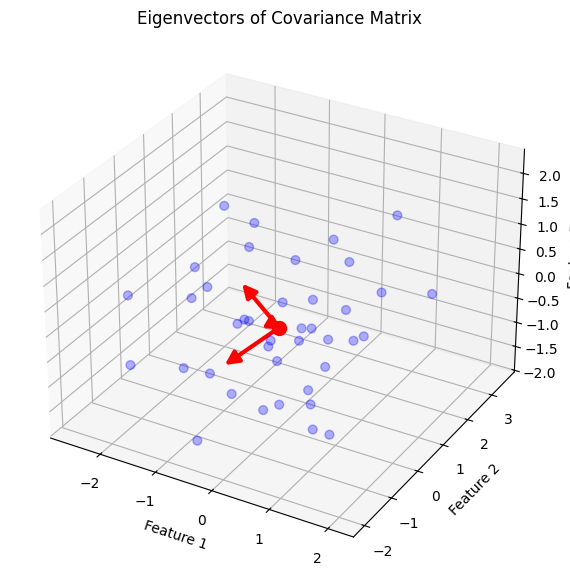

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

# ---------- Compute Eigenvectors ----------
X = df[['feature1', 'feature2', 'feature3']].values
X_centered = X - X.mean(axis=0)

cov_matrix = np.cov(X_centered.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Scale eigenvectors for visualization
eigen_vectors = eigen_vectors * np.sqrt(eigen_values)

# ---------- Arrow3D (fixed for new matplotlib) ----------
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# ---------- Plot ----------
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
ax.scatter(
    df['feature1'], df['feature2'], df['feature3'],
    color='blue', alpha=0.3, s=40
)

# Mean point
mean_x, mean_y, mean_z = X.mean(axis=0)
ax.scatter(mean_x, mean_y, mean_z, color='red', s=100)

# Eigenvectors
for v in eigen_vectors.T:
    arrow = Arrow3D(
        [mean_x, mean_x + v[0]],
        [mean_y, mean_y + v[1]],
        [mean_z, mean_z + v[2]],
        mutation_scale=20,
        lw=3,
        arrowstyle="-|>",
        color="red"
    )
    ax.add_artist(arrow)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('Eigenvectors of Covariance Matrix')
plt.show()


In [ ]:
# Step 4 - Selecting Principal Components
# Selecting top 2 eigen vectors for 2D projection
pc = eigen_vectors[0:2]
pc

array([[-0.62681716, -0.67449188,  0.42166572],
       [-0.76331741, -0.01028411, -0.66549365]])

In [ ]:
# Step 5 - Transforming the data to new basis
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 - 3,2
new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,1.749225,0.559905,1
1,-0.329752,-1.365653,0
2,0.717524,0.612773,1
3,-3.358227,-0.428801,0
4,-0.068994,-2.739875,0


In [16]:

new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()